In [ ]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns
import pandas as pd

import scipy.stats
import datetime
import matplotlib.pyplot as plt

# create agent

In [110]:
# subset = agents(agents.x > 5)
class WealthAgent(ap.Agent):
    """ An agent that makes `transactions"""
    def setup(self):
        self.name = ''
        self.mean = 0  
        self.txn_times = []
        self.zscores = []
        self.shifted_zscores = []

        self.acct_balance = 100
        self.txn_partners = []

        # pass in also.. the ... uh... the distribution of types of agents to
        # transact with

    # TODO: each agent should probably be fed p_txn table by the model 
    # vs. currently, model feeds p_txn, and mean
    def shift_zscores(self):
        shift = self.mean * 4 # WARNING hardcoded 4
        self.shifted_zscores = np.concatenate(
            (self.zscores[-shift:] , self.zscores[:-shift]))

    def transact(self, timestep):
        p_txn = self.shifted_zscores[timestep-1]
        if np.random.random() < p_txn:
            if self.acct_balance > 0:
                self.txn_times.append(timestep)
                partner = self.model.agents.random()
                print('transacted. timestep', timestep, f'ptxn: {p_txn:.3f}',
                'with partner: ', partner.id, 'new balance: ', self.acct_balance)
                partner.acct_balance += 50 
                self.acct_balance -= 50
                self.txn_partners.append(*partner.id)

# create model

In [111]:

class WealthModel(ap.Model):
    """ A simple model of random wealth transfers """
    def create_zscore(self):
        zscore_list = []
        # scipy norm has stddev = 1, mean of 0
        # assume all happens within 5 std devs per side of bell curve 
        max_std_devs = 5 
        steps_per_hr = int(60 / self.p.mins_per_step)
        # each side is 12 hours
        std_dev_per_step = (max_std_devs/12) / steps_per_hr 
        # Generate table of p's per step by integrating bell curve
        for step in range(int(self.p.steps/2)):
            p_txn = scipy.integrate.quad(
                            scipy.stats.norm.pdf, 
                            step * std_dev_per_step,
                            (step+1) * std_dev_per_step
                        )[0] # quad() Returns: value, error
            zscore_list.append(p_txn)
        zscores = zscore_list.copy()
        zscores = np.array(zscores)
        print('first zscore', zscores[0])
        print('last zscore', zscores[-1])
        # Center zscore at midnight (highest p_txn at midnight)
        zscores = np.append(
            zscores,
            np.flip(zscores))
        if False: # For debugging, can set p_txn to 1 to always transact
            zscores[0] = 1
            zscores[-1] = 1
            zscores[1:-1] = 0
        print('num zscores', len(zscores))#, 'zscores', zscores)
        print('- '*10)
        return zscores

    def setup(self):
        # WARNING: is setting avg num txns = 3 appropriate? probably not
        self.avg_num_txns = 3 # arbitrarily defined
        self.zscores = self.create_zscore()
        self.zscores = self.avg_num_txns * self.zscores 
        # self.p for parameters

        # Create agents
        self.agents = ap.AgentList(self, 
            self.p.num_agents_normal + self.p.num_agents_suspicious, 
            WealthAgent) 

        # Set mean for each agent by creating int for each agent
        # TODO: refactor so select by agent type and assign same mean
        # instead of this nonsense
        names = \
            ['normal'] * self.p.num_agents_suspicious + \
            ['suspicious'] * self.p.num_agents_suspicious
        mean_txn_normal = self.p.mean_txn_hrs['normal']
        mean_txn_suspicious = self.p.mean_txn_hrs['suspicious']
        means = \
            [mean_txn_normal] * self.p.num_agents_normal + \
            [mean_txn_suspicious] * self.p.num_agents_suspicious
        self.agents.mean = ap.AttrIter(means)
        self.agents.name = ap.AttrIter(names)
        # Same p_txn table (centered at midnight) for all agents
        self.agents.zscores = self.zscores 

        # now that we've set the means 
        # we can update the p_txn table for each agent
        for agent in self.agents:
            agent.shift_zscores() 
            #print('mean', agent.mean)
            #print('zscore', agent.shifted_zscores)

    def step(self):
        """ Define the models' events per simulation step. """
        self.agents.transact(self.t)

    def update(self):
        """ Record variables after setup and each step. """
        #self.record('txn or not', self.txn, self.txn_time)
        total_txns = 0
        for agent in self.agents:
            total_txns += len(agent.txn_times)
        self.record('num txns (across all agents)', total_txns)

    def end(self):
        self.agents.record('txn_times')  # must be attribute
        self.agents.record('txn_partners')  # must be attribute
        self.agents.record('acct_balance')  # must be attribute

In [112]:
MEAN_TXN_HRS = {'normal':14, 
                'suspicious':22}
MINS_PER_STEP = 15
MEAN_TXN_VALUES = {'normal':250, 
                'suspicious':50}

# AGENT assumptions
# - avg. # txn / day (FUTURE: mean + stddev)
# - avg. $ txn amt
# eg - multiple small transactions, or a few large ones

parameters = {
    'num_agents_normal':1000,
    'num_agents_suspicious':100,

    'mean_txn_hrs':MEAN_TXN_HRS,
    'seed': 42,
    'mins_per_step' : MINS_PER_STEP, # 1 hr
    'steps': 24 * (60/MINS_PER_STEP), # 24 hours * steps per hr
    'mean_txn_values': MEAN_TXN_VALUES,
    'starting_balance': 100,
}


# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

# run model

In [113]:
model = WealthModel(parameters)
results = model.run()

first zscore 0.041481456911556636
last zscore 2.0279846144161732e-07
num zscores 96
- - - - - - - - - - 
transacted. timestep 1 ptxn: 0.084 with partner:  [564] new balance:  100
transacted. timestep 1 ptxn: 0.084 with partner:  [502] new balance:  100
transacted. timestep 1 ptxn: 0.084 with partner:  [458] new balance:  100
transacted. timestep 1 ptxn: 0.084 with partner:  [286] new balance:  100
transacted. timestep 1 ptxn: 0.084 with partner:  [210] new balance:  100
Completed: 1 stepstransacted. timestep 2 ptxn: 0.076 with partner:  [179] new balance:  100
transacted. timestep 2 ptxn: 0.076 with partner:  [865] new balance:  100
transacted. timestep 2 ptxn: 0.076 with partner:  [66] new balance:  100
transacted. timestep 2 ptxn: 0.076 with partner:  [62] new balance:  100
transacted. timestep 2 ptxn: 0.076 with partner:  [192] new balance:  100
transacted. timestep 2 ptxn: 0.076 with partner:  [448] new balance:  100
transacted. timestep 2 ptxn: 0.076 with partner:  [477] new balan

# analyze results

In [106]:
all_txns = []
all_agents = []

for agent in model.agents:
    print(agent.id, 'with txns at timesteps: ',  agent.txn_times)
    print('and at times: ') 
    for timestamp in agent.txn_times:
        print( timestep_to_time(timestamp).strftime(
            '%H:%M')
        )
        all_agents.append(agent.id)
        all_txns.append(timestep_to_time(timestamp))
    print('the partners were: ', agent.txn_partners) 
all_txns = pd.DataFrame(
    zip(all_agents, all_txns), columns=['agent_id', 'txn_time'])
#all_txns
#all_txns.dtypes

1 with txns at timesteps:  [39, 53, 58, 70]
and at times: 
09:45
13:15
14:30
17:30
the partners were:  [765, 499, 512, 739]
2 with txns at timesteps:  [45, 61, 66]
and at times: 
11:15
15:15
16:30
the partners were:  [1048, 178, 821]
3 with txns at timesteps:  [48, 55, 56, 57, 59, 60]
and at times: 
12:00
13:45
14:00
14:15
14:45
15:00
the partners were:  [156, 821, 370, 1040, 654, 1028]
4 with txns at timesteps:  [47, 48, 54, 71]
and at times: 
11:45
12:00
13:30
17:45
the partners were:  [339, 498, 60, 311]
5 with txns at timesteps:  [48, 56, 64, 67]
and at times: 
12:00
14:00
16:00
16:45
the partners were:  [209, 439, 65, 886]
6 with txns at timesteps:  [48, 53, 55, 60]
and at times: 
12:00
13:15
13:45
15:00
the partners were:  [618, 258, 1074, 966]
7 with txns at timesteps:  [53, 59, 72]
and at times: 
13:15
14:45
18:00
the partners were:  [421, 496, 1082]
8 with txns at timesteps:  [55, 64, 81, 83]
and at times: 
13:45
16:00
20:15
20:45
the partners were:  [162, 192, 248, 304]
9 wit

In [107]:
all_txns.index = all_txns.txn_time
#resampled = all_txns.txn_time.resample('15Min')#.count().plot()

resampled = all_txns.txn_time.resample('1H')#.count().plot()
resampled.count()
df = pd.DataFrame(resampled.count())
df.columns=['value']
df['labels'] = pd.to_datetime(df.index).strftime('%H:%M')


# plot

<AxesSubplot:xlabel='acct_balance', ylabel='Count'>

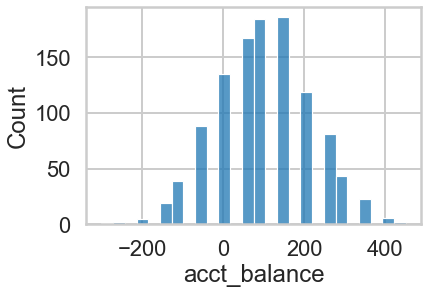

In [108]:
sns.histplot(results.variables.WealthAgent.acct_balance)

In [73]:
#left = datetime.date(2022, 10, 30)
#right = datetime.date(2022, 11, 1)
# 4pm and 10pm
#timerange = pd.date_range(start='10/30/2022 12:00', end='11/01/2022 12:00', freq='15Min')
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x='txn_time', y='value', data=df, ax=ax,
    markers=True,  marker='o')
sns.set_style('whitegrid')
sns.set_context('poster')
ax.set(xlabel='Time (24 Hour)', ylabel='# of Transactions',
title=r"$\bf{Simulated\ Transactions\ by\ Time–of–Day}$" 
    f"\nNum. accounts, Normal: {parameters['num_agents_normal']}, "
    f"Suspicious: {parameters['num_agents_suspicious']}\n"
    f"Mean txn time, Normal: {parameters['mean_txn_hrs']['normal']}:00,"
    f" Suspicious: {parameters['mean_txn_hrs']['normal']}:00"
    )
#barp.set_xbound(left, right)
# change axes?
#display(df.labels)
#ax.set_xticks(df['txn_time'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(len(df.labels)))
#ax.set(xticklabels=df['labels'])
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

Locator attempting to generate 19273 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 19273 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 38545 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 19273 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 19273 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 38545 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 19273 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 19273 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 38545 ticks ([18493.0, ..., 20099.0]), which exceeds Locator.MAXTICKS (1000).


Error in callback <function flush_figures at 0x17f274a60> (for post_execute):


KeyboardInterrupt: 